In [1]:
# license: GPL v3
# authors: Michael Olesik, Piotr Bartman, Sylwester Arabas
# copyright: Jagiellonian University
# based on Fig. 2 from Yang et al. 2018 (http://dx.doi.org/10.5194/acp-18-7313-2018)

In [2]:
# make local files accessible to import statements
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from PySDM_examples.Yang_et_al_2018_Fig_2.example import Simulation
from PySDM_examples.Yang_et_al_2018_Fig_2.setup import Setup
from PySDM.simulation.physics import formulae as phys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [89]:
setup = Setup()

setup.condensation_scheme = 'libcloud'

setup.rtol_thd = 1e-7
setup.rtol_lnv = 1e-6

simulation = Simulation(setup)
output = simulation.run()
print(simulation.particles.stats.wall_times[-1]*1000)

0.7933370070531964


In [90]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [91]:
r = np.array(output["r"]).T * si.metres
t = output["t"] * si.seconds
z = output["z"] * si.metres
S = np.array(output["S"]) * si.dimensionless
q = (setup.q0 - np.array(output["qv"])) * si.kilogram / si.kilogram
T = np.array(output["T"])
n = setup.n / (setup.mass_of_dry_air  * si.kilogram)

In [92]:
ix51 = 40
ix503 = 99
assert round(setup.r_dry[  ix51]*1e9, 0) == 51
assert round(setup.r_dry[ ix503]*1e9, 0) == 503

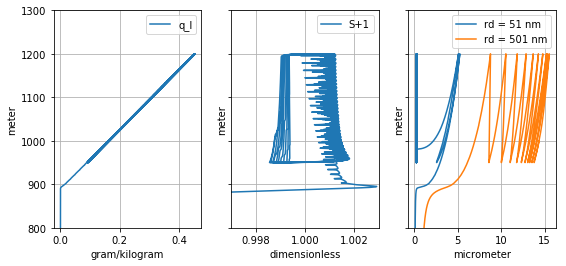

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

ax1.set_ylim([800, 1300])
ax1.plot(q, z, label="q_l")
ax1.xaxis.set_units(si.gram / si.kilogram)
ax1.grid()
ax1.legend()

ax2.plot(S+1, z, label="S+1")
ax2.grid()
ax2.legend()
ax2.set_xlim([0.997, 1.003])

ax3.plot(r[ix51], z, label="rd = 51 nm")
ax3.plot(r[ix503], z, label="rd = 501 nm")
ax3.grid()
ax3.xaxis.set_units(si.micrometre)
ax3.legend()

In [94]:
hist, xedges, yedges = np.histogram2d(
    t.magnitude.reshape(1,-1).repeat(r.shape[0], axis=0).ravel(), 
    r.magnitude.ravel(),
    bins = [256,128], 
    weights = n.magnitude.reshape(-1,1).repeat(r.shape[1], axis=1).ravel(),
)

In [95]:
arg_r_dry = setup.r_dry 
arg_T = T.reshape(-1,1).repeat(len(n), axis = 1)
r_cr = phys.r_cr(setup.kappa, arg_r_dry, arg_T).transpose()

In [96]:
def rmean(r, n, mask):
    nt = r.shape[1]
    n_dot_r = n.magnitude.dot(np.where(mask, r.magnitude, 0))
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(nt, axis=1), 0), axis=0)
    rmean = np.full(nt, np.nan)
    nmask = n_tot > 0
    rmean[nmask] = n_dot_r[nmask] / n_tot[nmask]
    return rmean * r.units

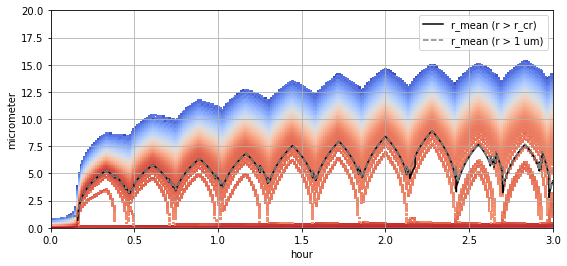

In [97]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(1, 1,  figsize=(9,4))

xunit = si.hour
yunit = si.micrometres

ax.yaxis.set_units(yunit)
ax.xaxis.set_units(xunit)
ax.set_ylim([0, 20])
c = ax.pcolormesh(
    mgn(xedges * t.units, xunit), 
    mgn(yedges * r.units, yunit), 
    hist.T,
    cmap = 'coolwarm',
    norm = mpl.colors.LogNorm()
)
ax.plot(t, rmean(r, n, r.magnitude > r_cr), label="r_mean (r > r_cr)", color='black')
ax.plot(t, rmean(r, n, r > 1 * si.micrometre), label="r_mean (r > 1 um)", linestyle='--', color='gray')
ax.legend()
ax.grid()